In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

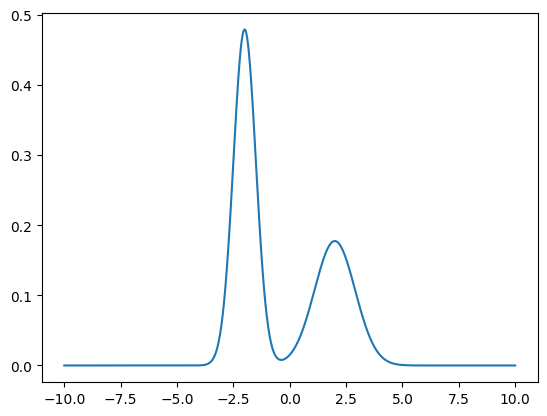

In [2]:
# general formula for a univariate Gaussian
def gaussian(x, mu, sigma):
    return 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

# sample points
x = torch.linspace(-10, 10, 1000)

# Gaussian mixture parameters
mu_1, mu_2 = 2, -2
sigma_1, sigma_2 = 0.9, 0.5
pi = 0.4
p = lambda x: pi*gaussian(x, mu_1, sigma_1) + (1-pi)*gaussian(x, mu_2, sigma_2)

# compute distribution
p_x = p(x)
plt.plot(x, p_x)

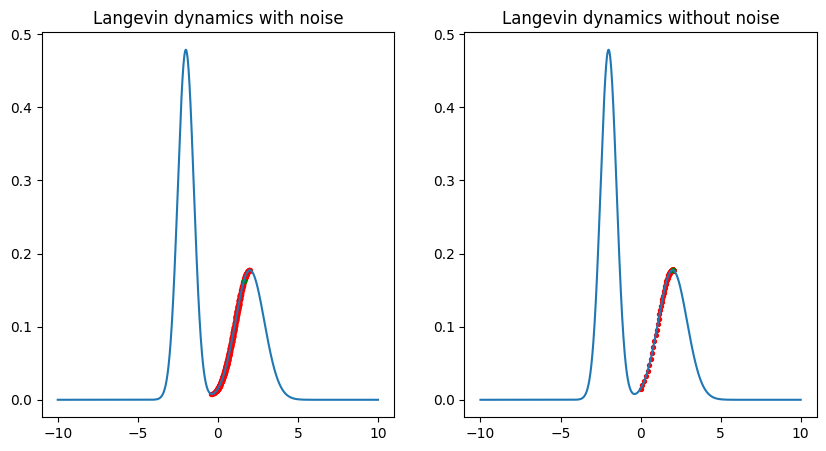

In [3]:
# langevin dynamics steps
n_steps = 800

# x_t without noise (gradient ascent)
x_ts_no_noise = []
# x_t with noise (stochastic gradient ascent)
x_ts = []

# step size
tau_no_noise = 0.05
tau = 0.008

# initial point
x_t_no_noise = torch.tensor(0., requires_grad=True)
x_t = torch.tensor(0., requires_grad=True)

for step in range(n_steps):
    
    # deterministic gradient ascent
    x_ts_no_noise.append(x_t_no_noise.item())
    if x_t_no_noise.grad is not None: x_t_no_noise.grad.zero_()
    
    p(x_t_no_noise).log().backward()
    x_t_no_noise = (x_t_no_noise + tau_no_noise * x_t_no_noise.grad).clone().detach().requires_grad_(True)
    
    # stochastic gradient ascent
    x_ts.append(x_t.item())
    if x_t.grad is not None: x_t.grad.zero_()
    
    p(x_t).log().backward()
    x_t = (x_t + .5*tau * x_t.grad + tau**.5 * torch.randn(1)).clone().detach().requires_grad_(True)
    

x_ts = torch.tensor(x_ts)
x_ts_no_noise = torch.tensor(x_ts_no_noise)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title("Langevin dynamics with noise")
ax1.plot(x, p_x)
ax1.scatter(x_ts, p(x_ts), s=8, c='r')
ax1.scatter(x_t.detach(), p(x_t.detach()), s=10, c='g')

ax2.set_title("Langevin dynamics without noise")
ax2.plot(x, p_x)
ax2.scatter(x_ts_no_noise, p(x_ts_no_noise), s=8, c='r')
ax2.scatter(x_t_no_noise.detach(), p(x_t_no_noise.detach()), s=10, c='g')

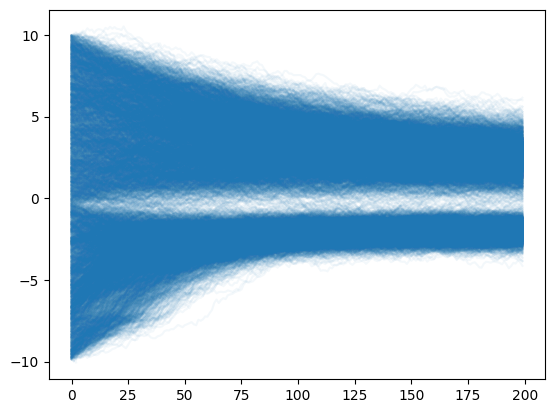

In [8]:
n_steps = 200

x_ts = []

tau = 0.007
n_samples = 5000
x_t = (torch.rand(n_samples) * 20 - 10).requires_grad_(True)

for step in range(n_steps):
    x_ts.append(x_t.detach())
    if x_t.grad is not None: x_t.grad.zero_()
    
    p(x_t).log().backward(torch.ones_like(x_t))
    x_t = (x_t + tau * x_t.grad + (2*tau)**.5 * torch.randn_like(x_t)).clone().detach().requires_grad_(True)
    # tau = tau * 0.99


x_ts = torch.stack(x_ts)

plt.plot(x_ts, c='C0', alpha=0.05)
plt.show()

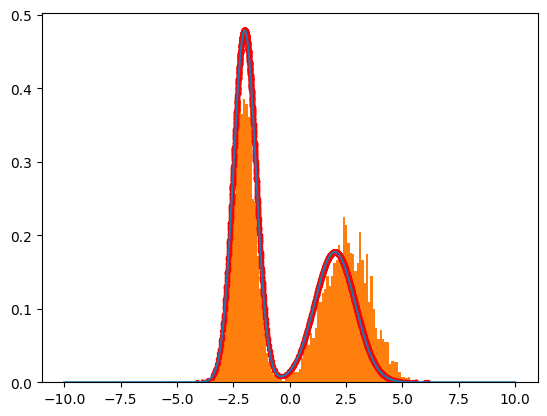

In [10]:
plt.plot(x, p_x)
plt.hist(x_ts[-1], density=True, bins=100)
plt.scatter(x_ts[-1], p(x_ts[-1]), s=8, c='r')
plt.show()

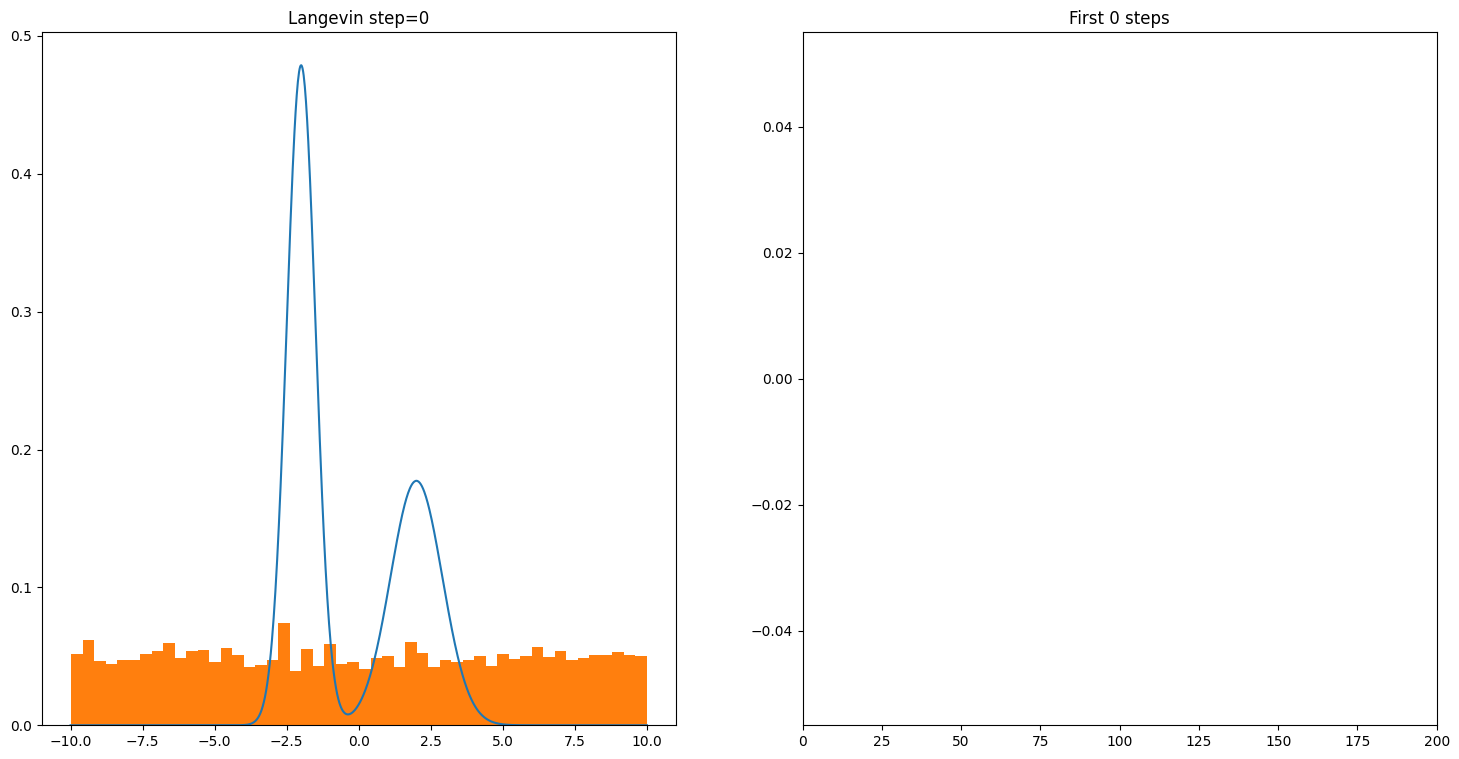

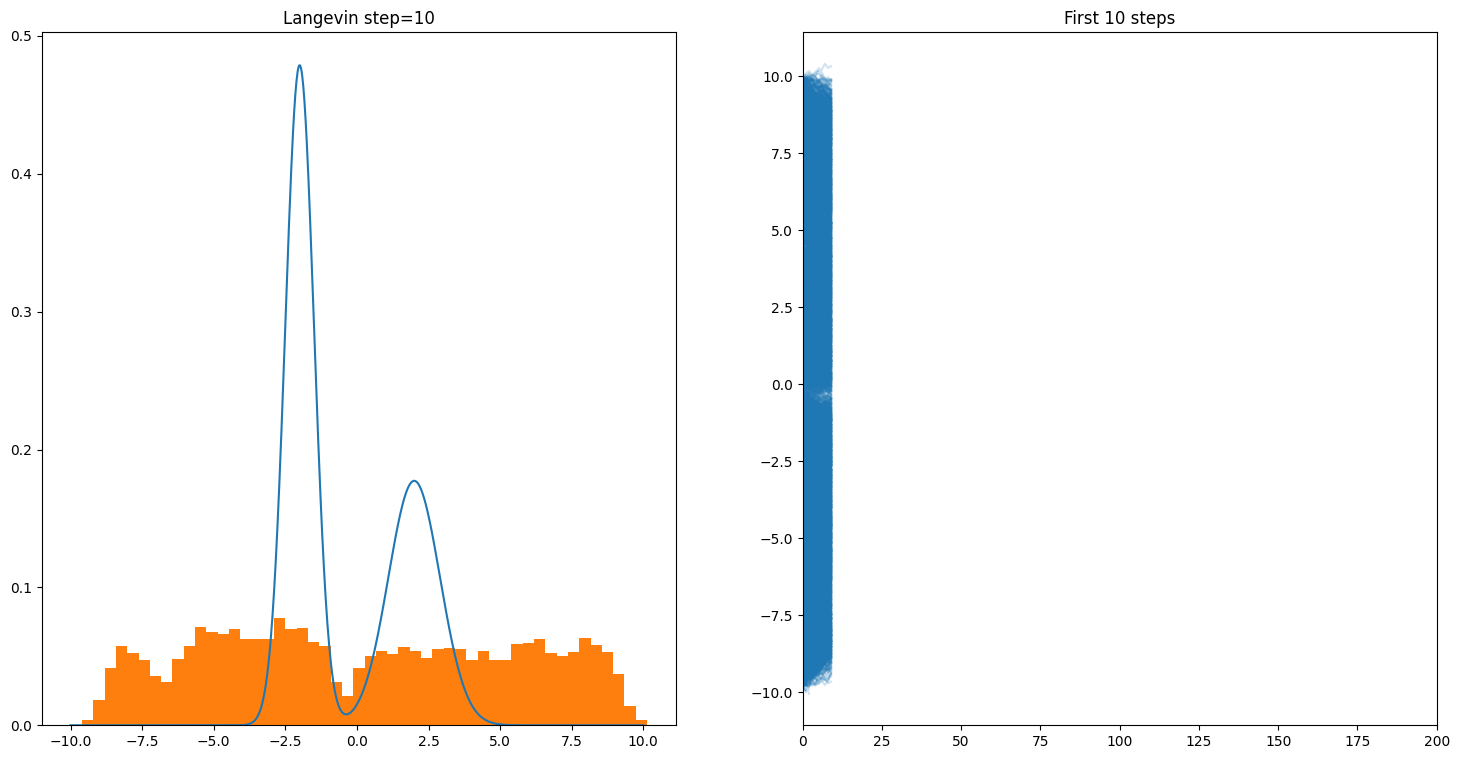

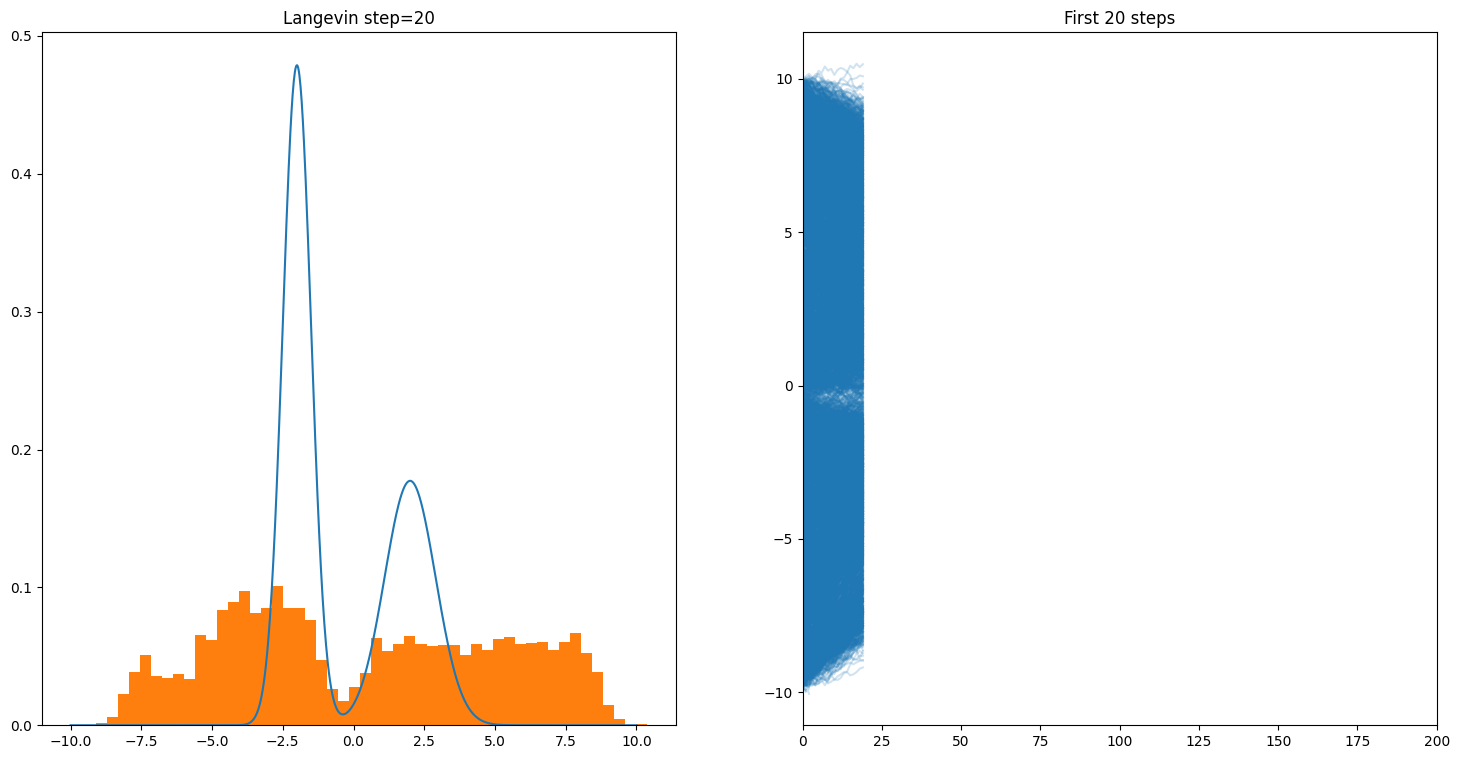

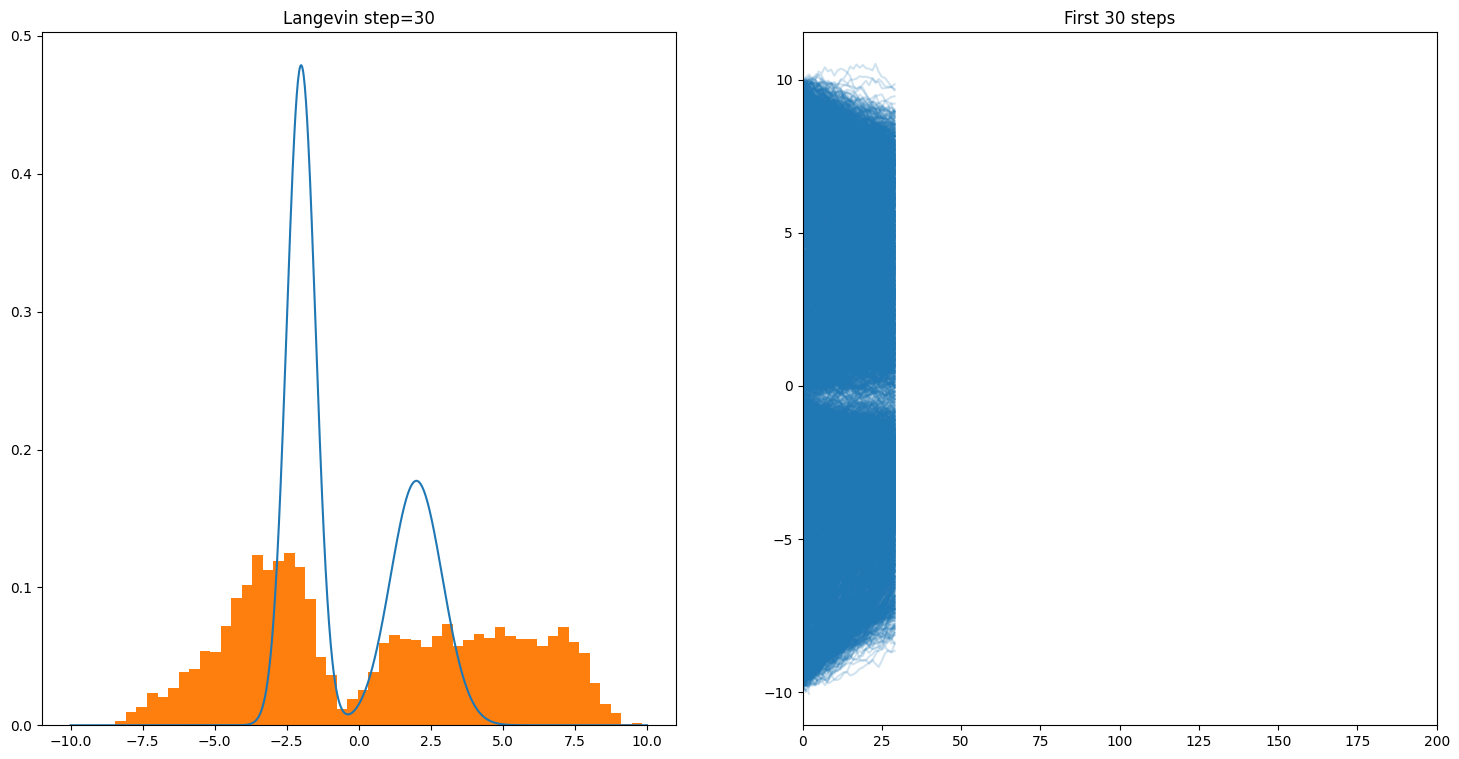

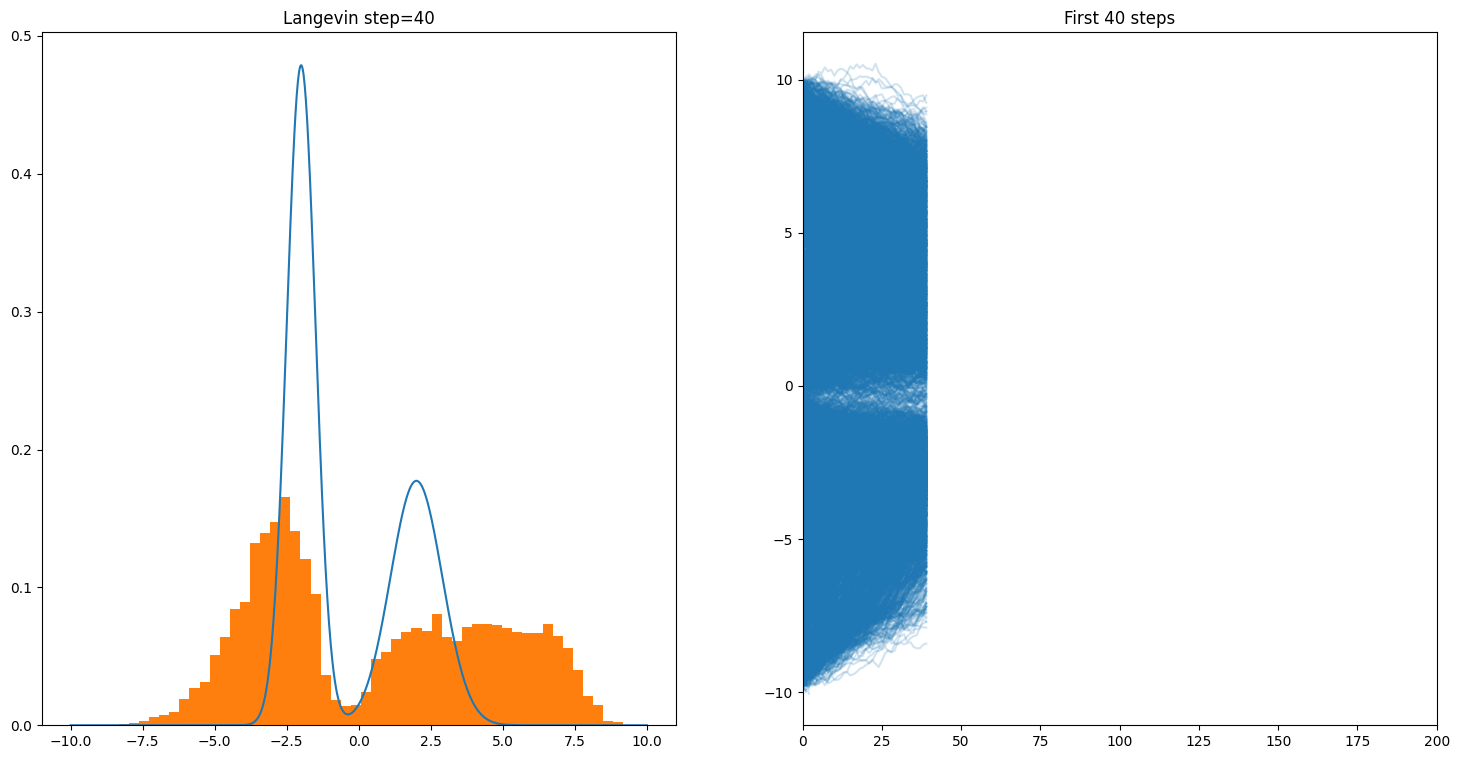

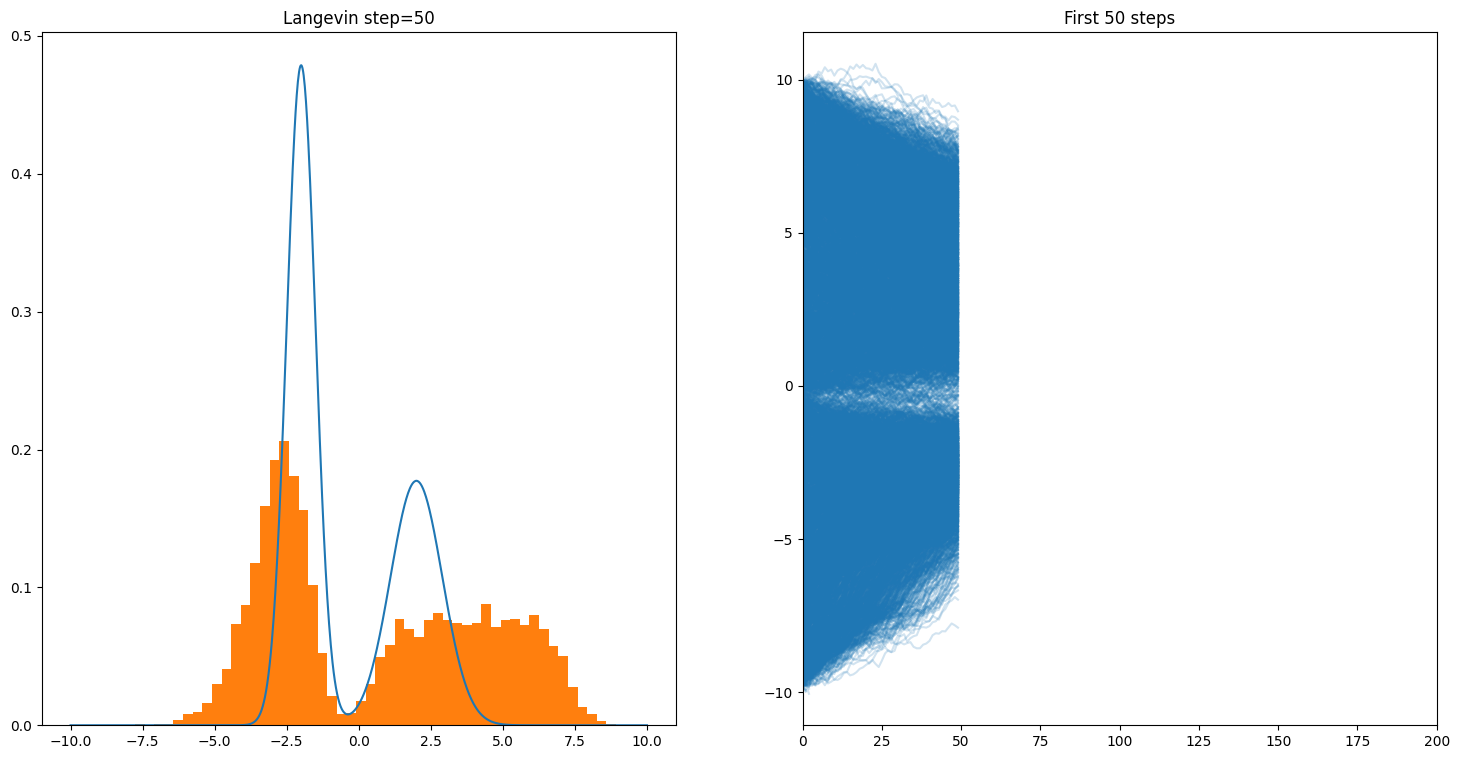

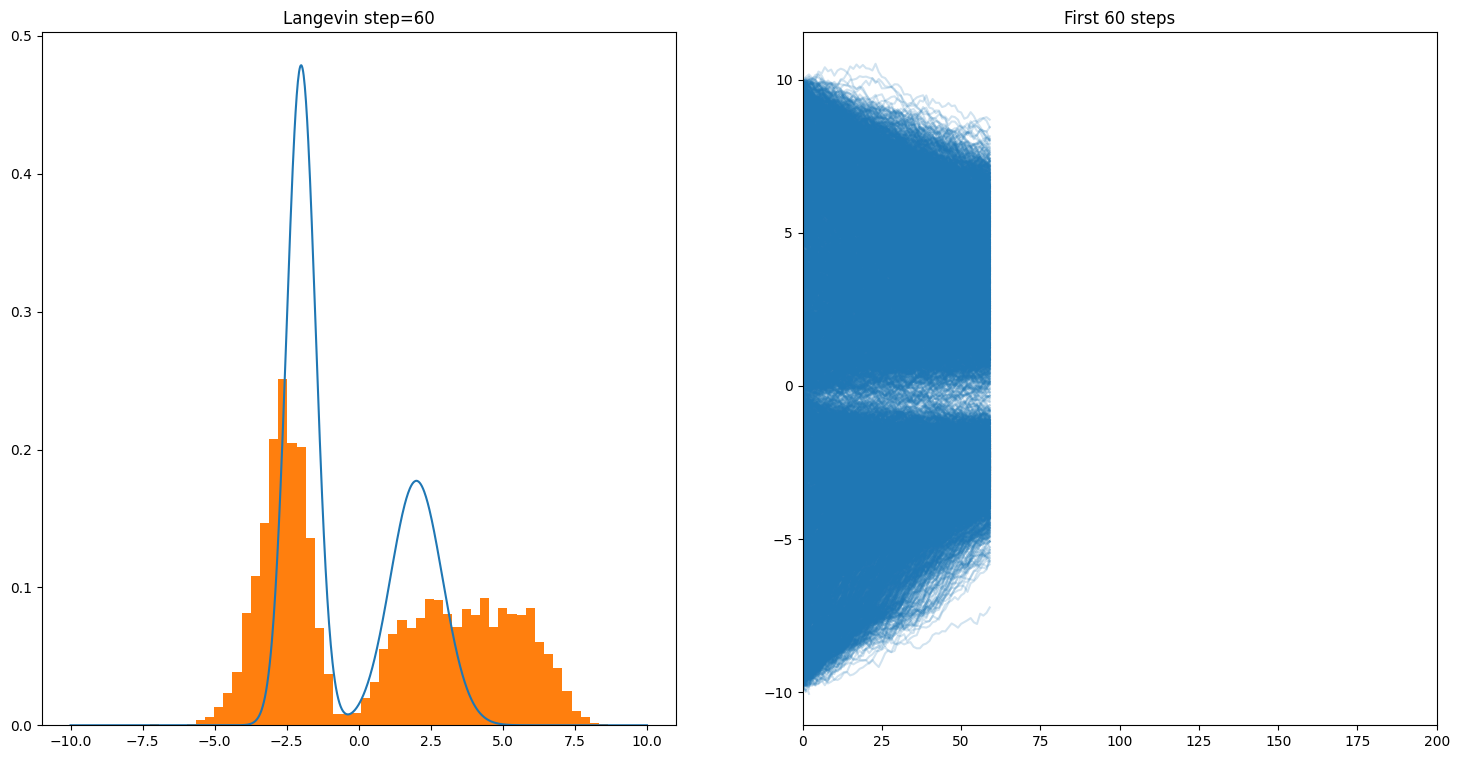

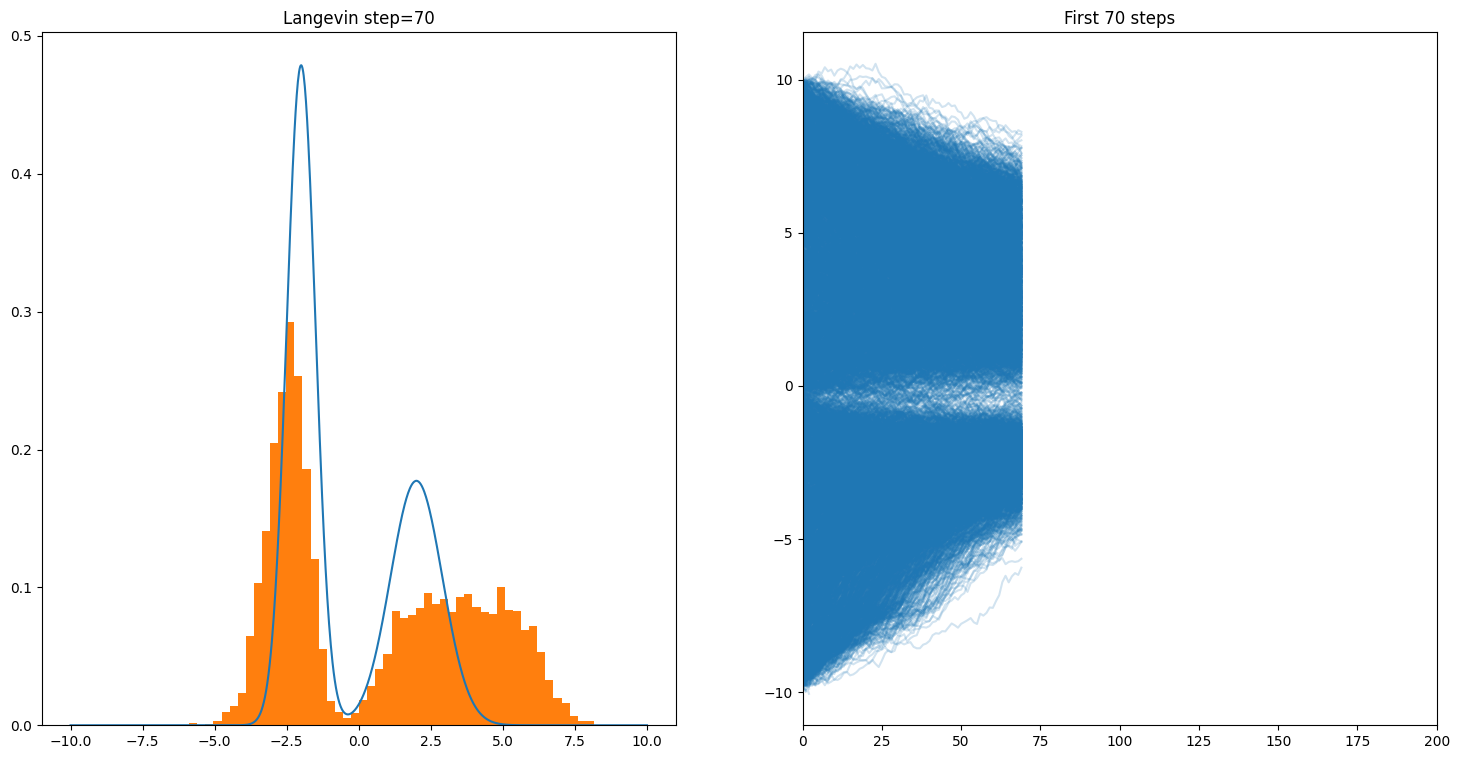

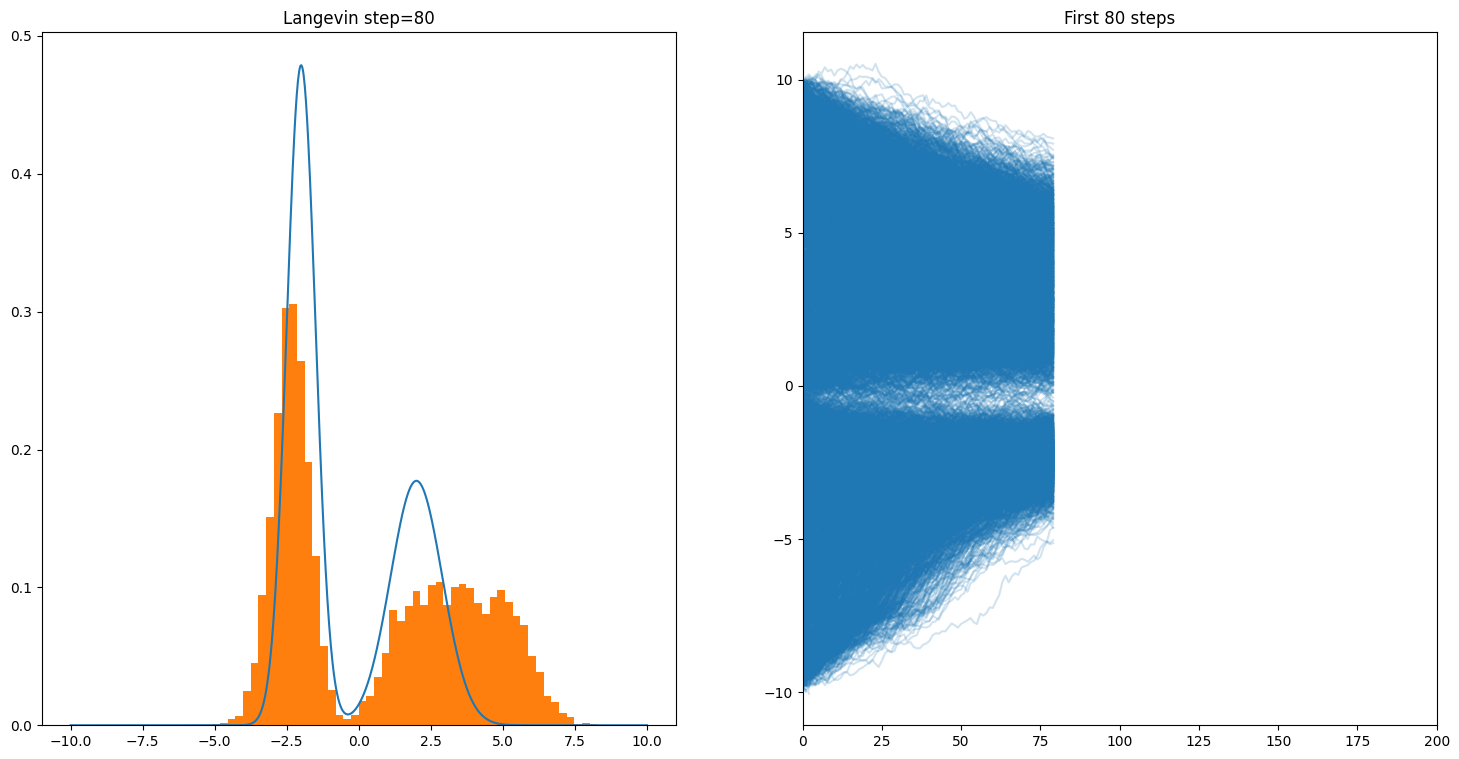

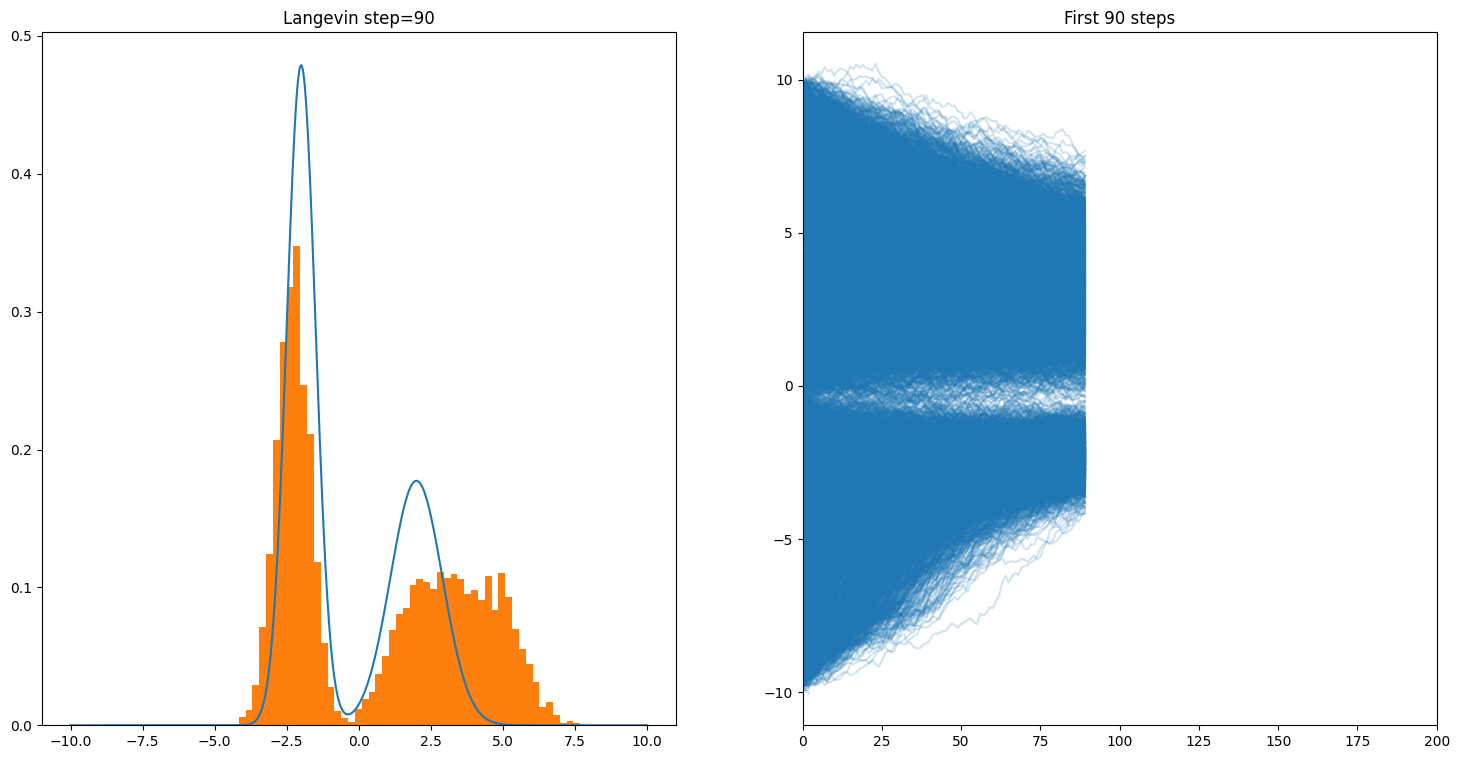

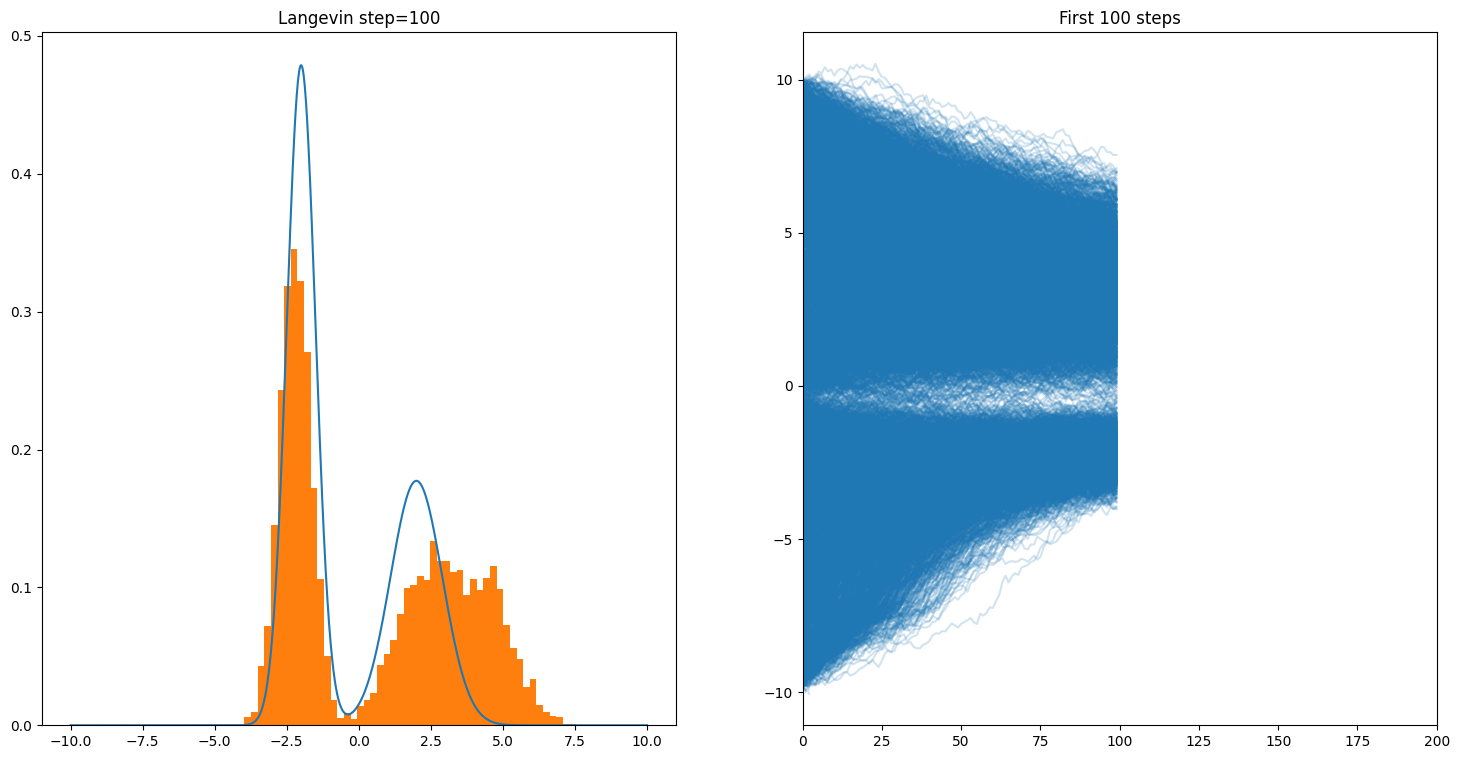

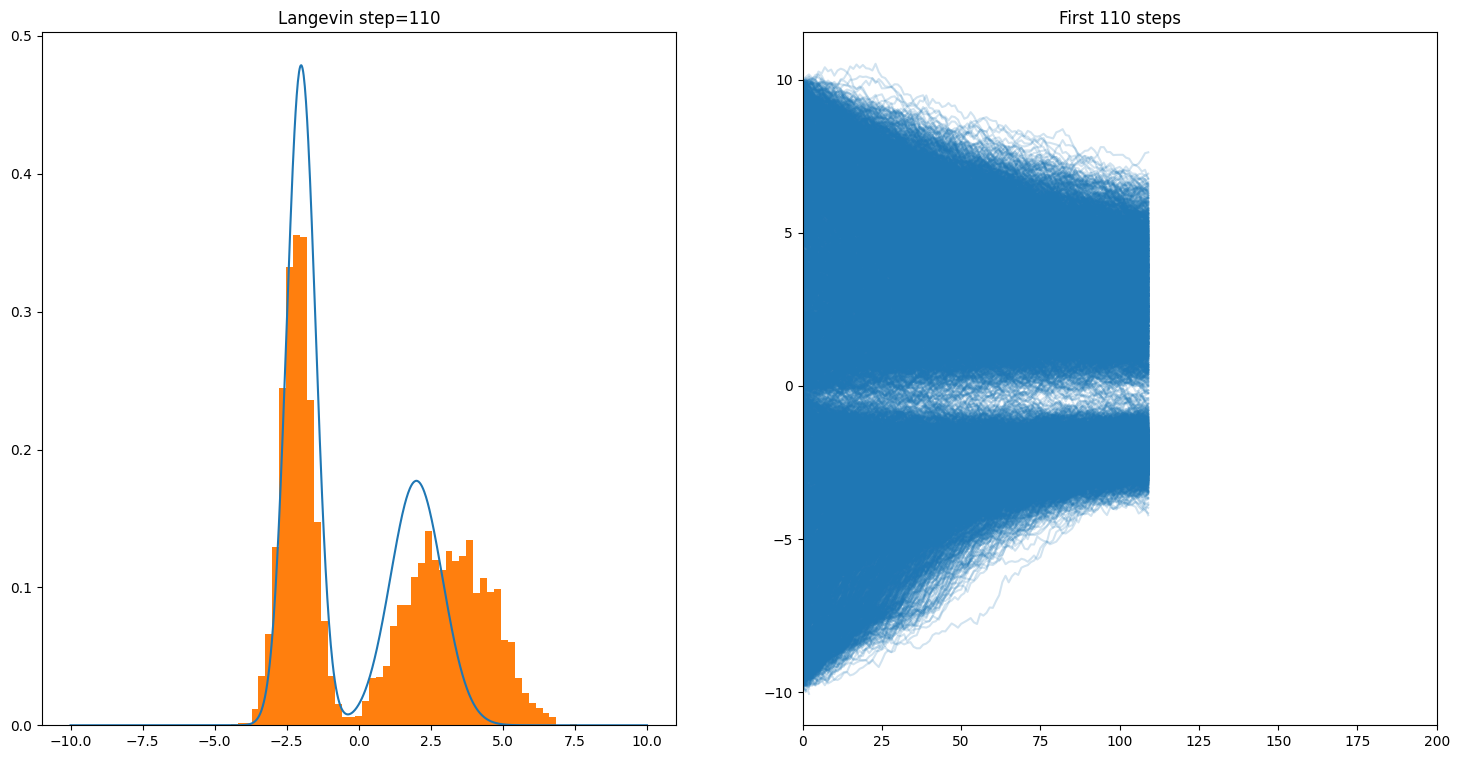

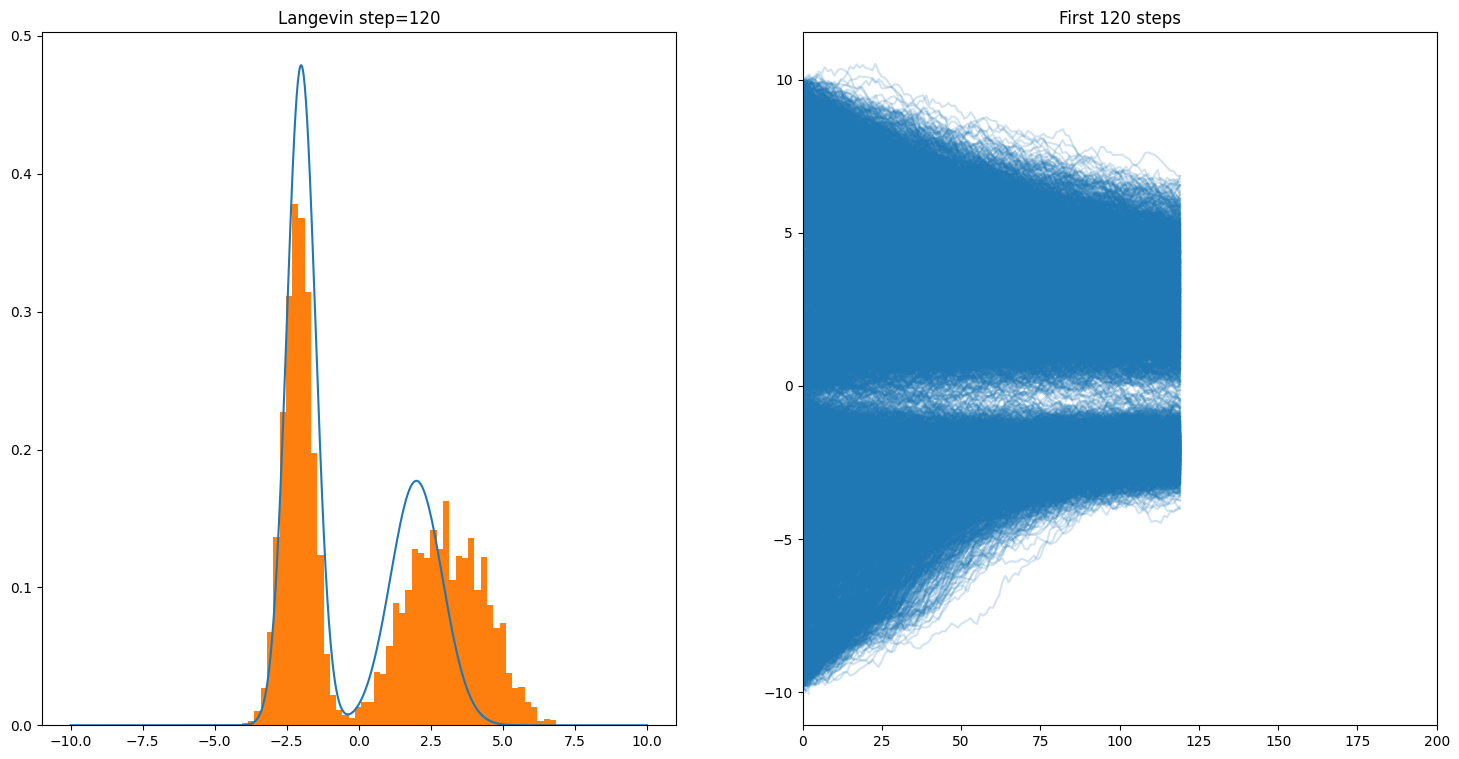

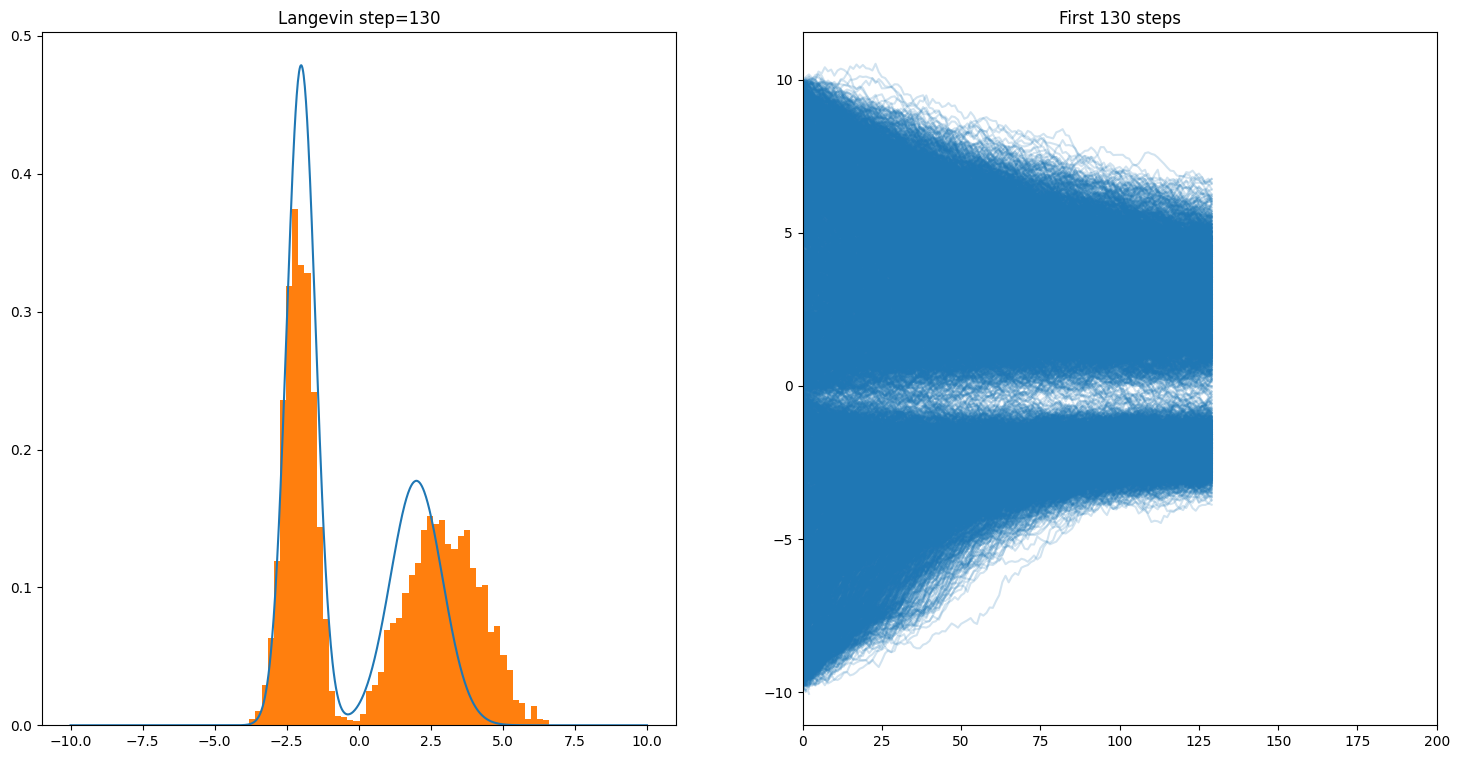

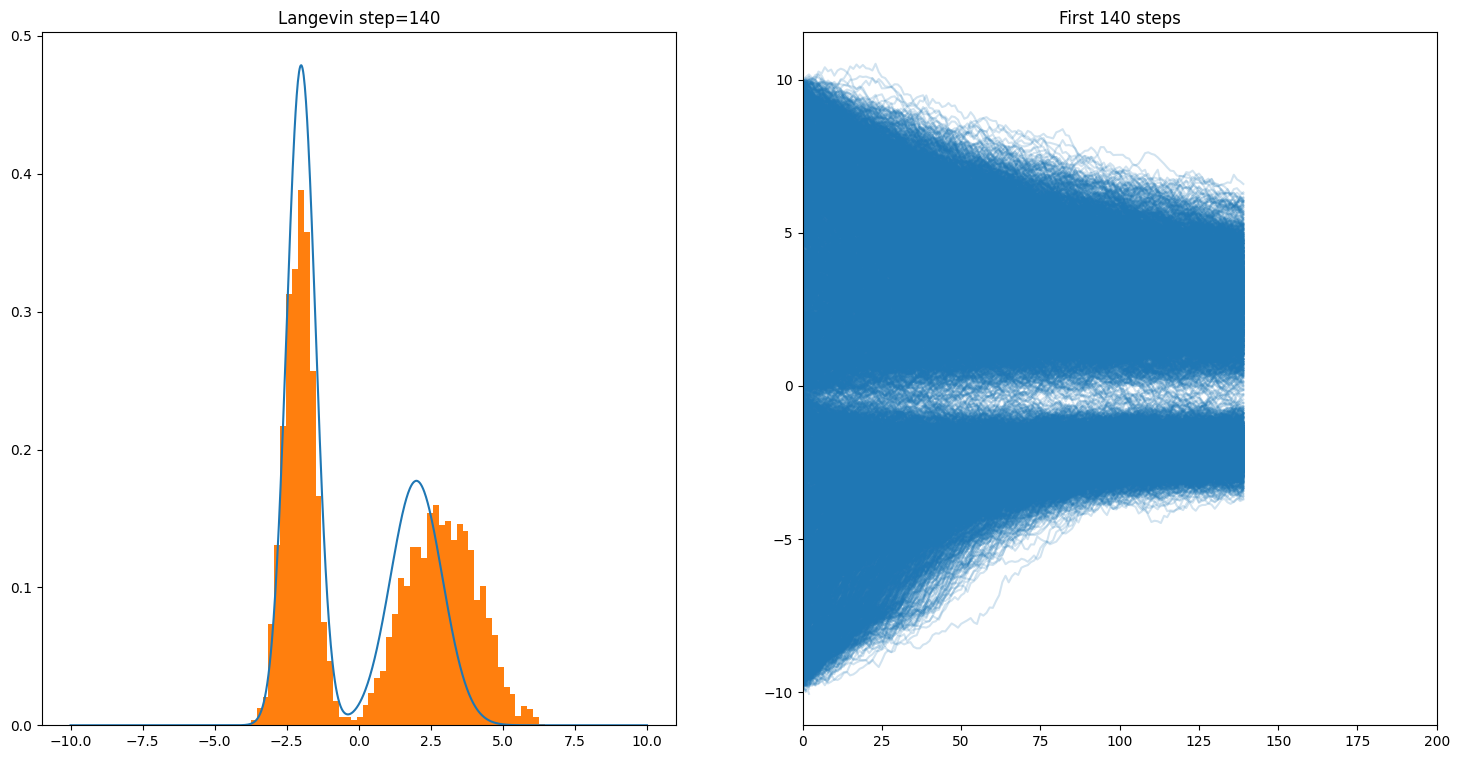

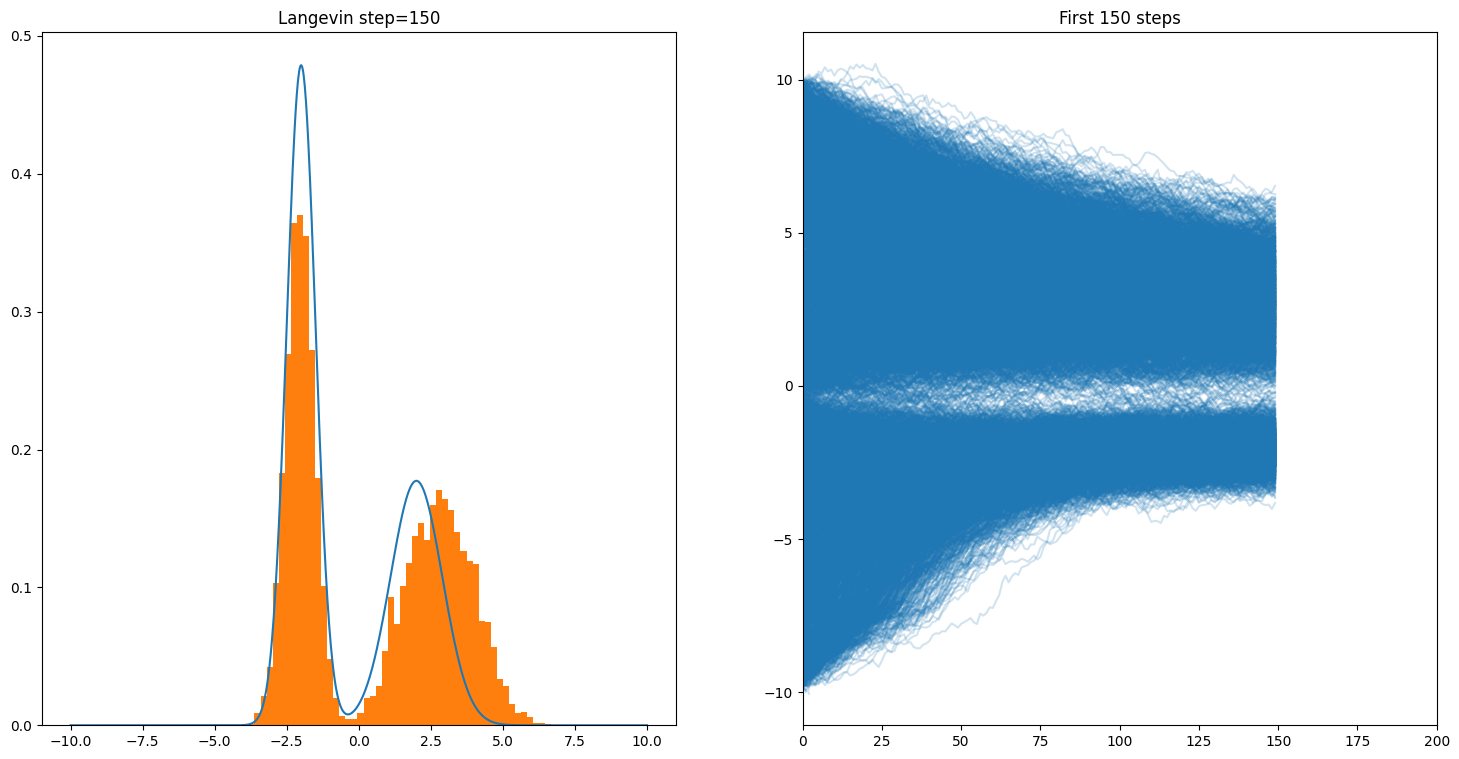

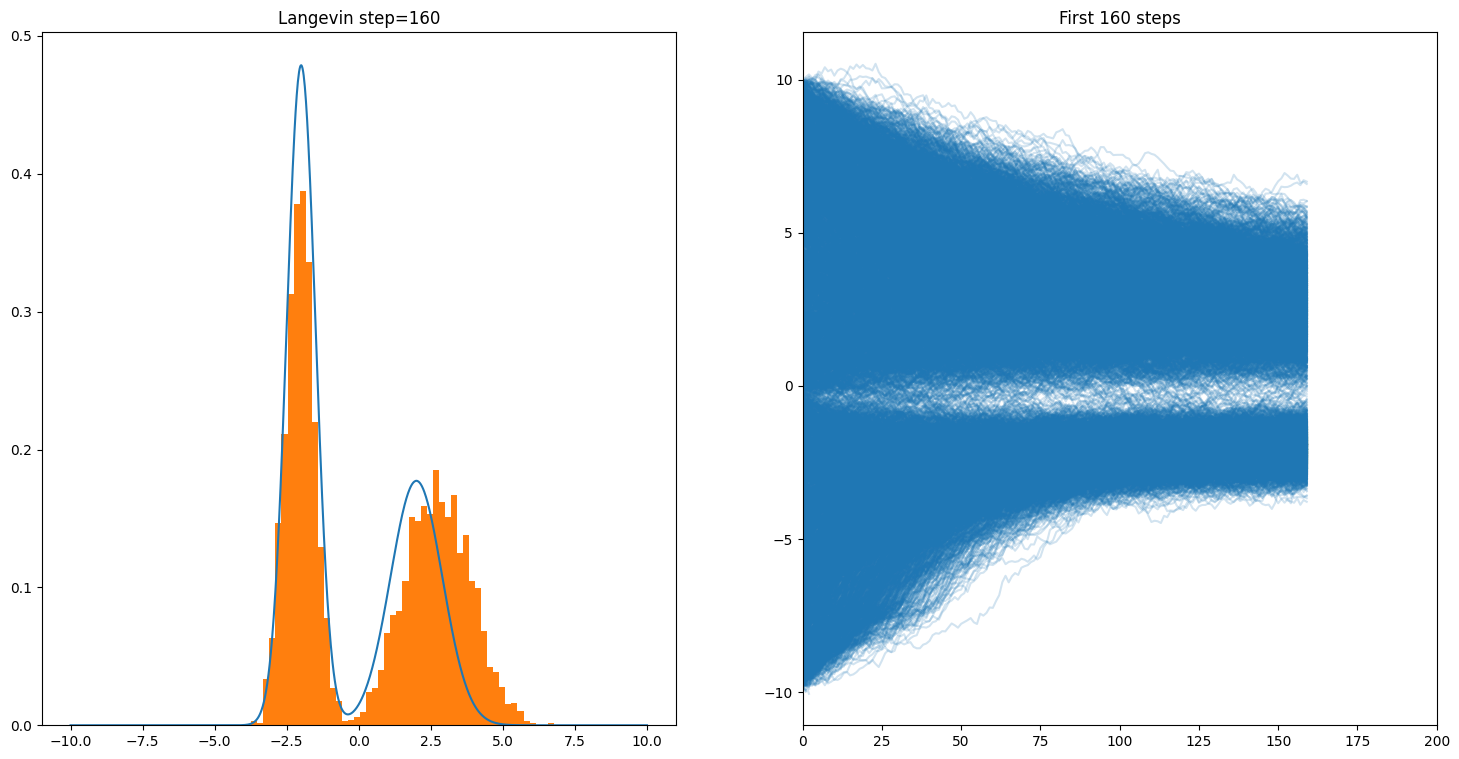

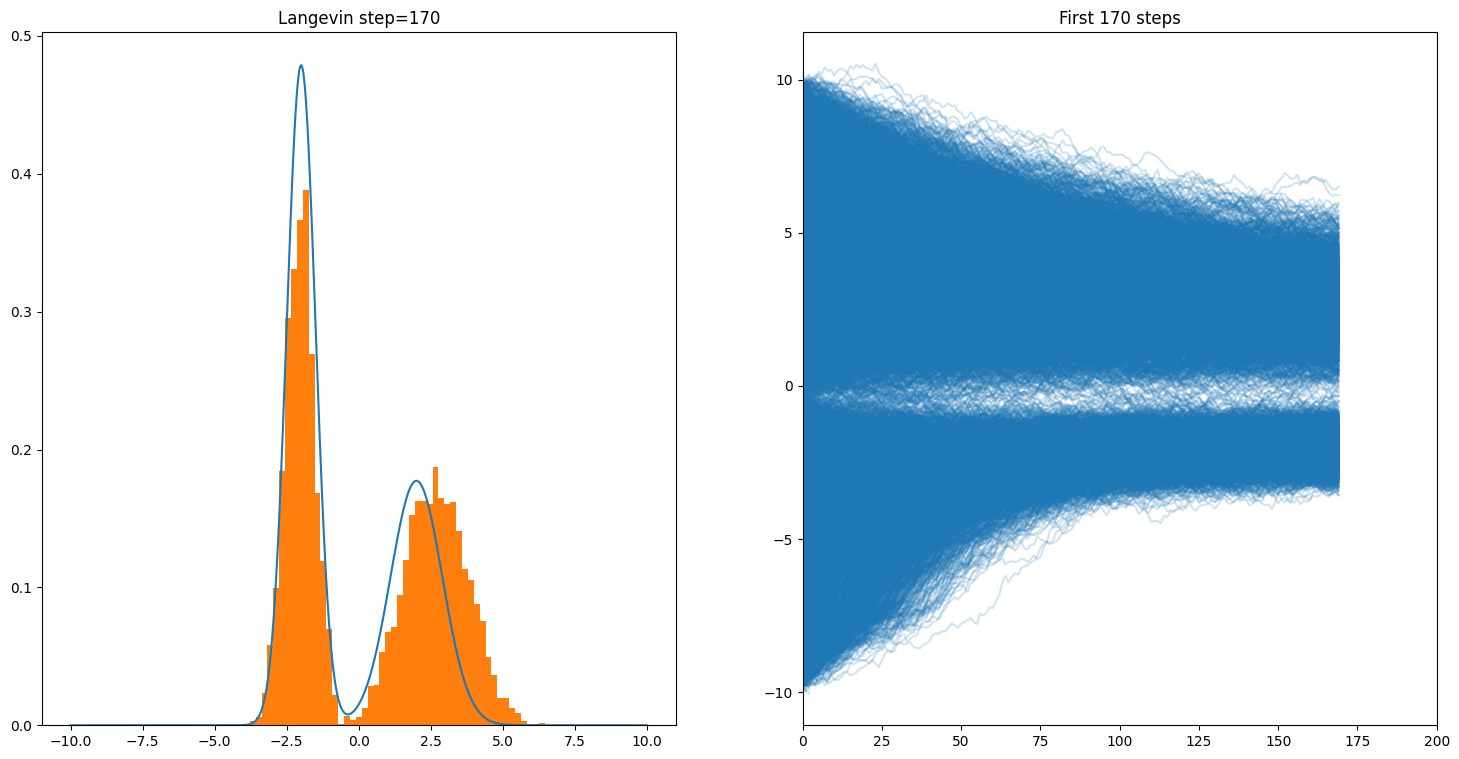

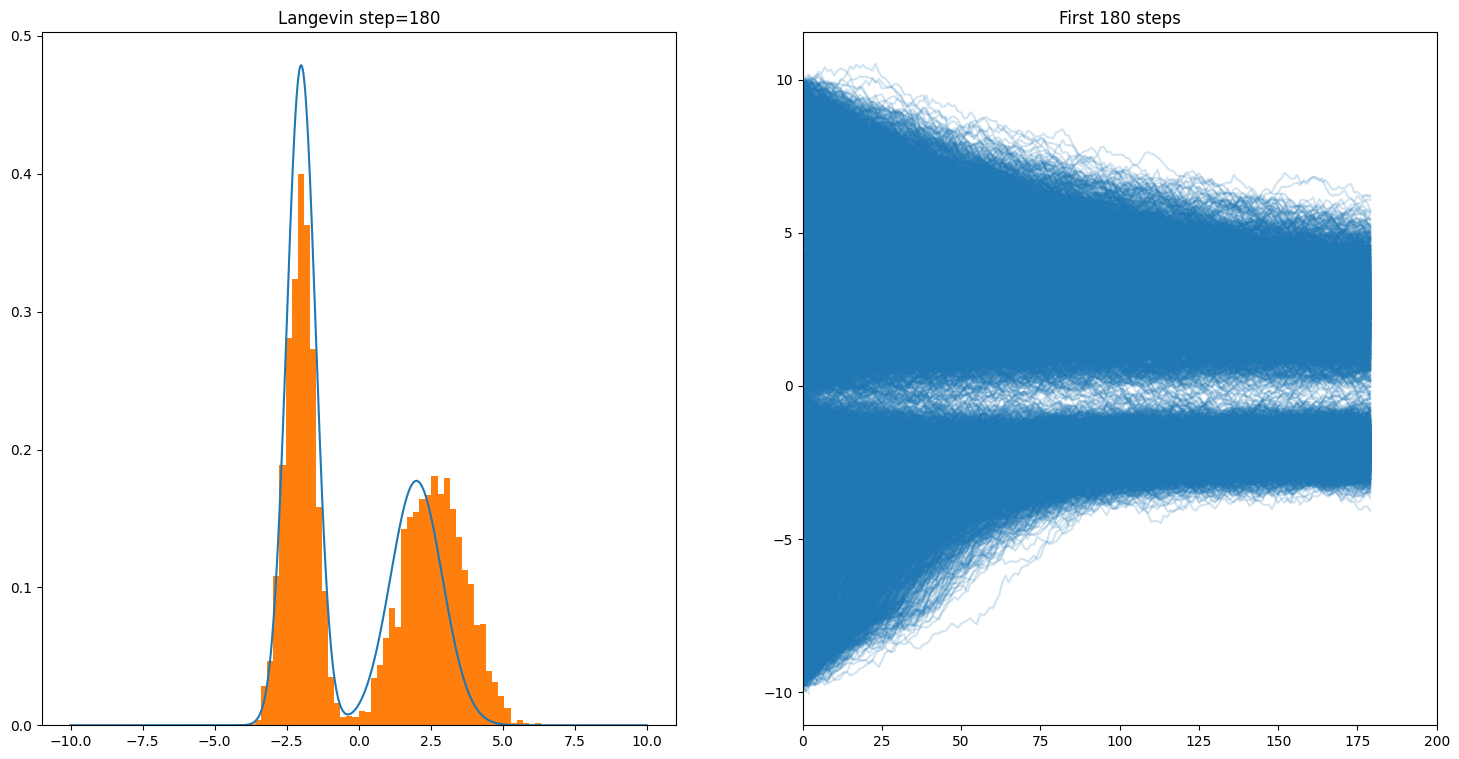

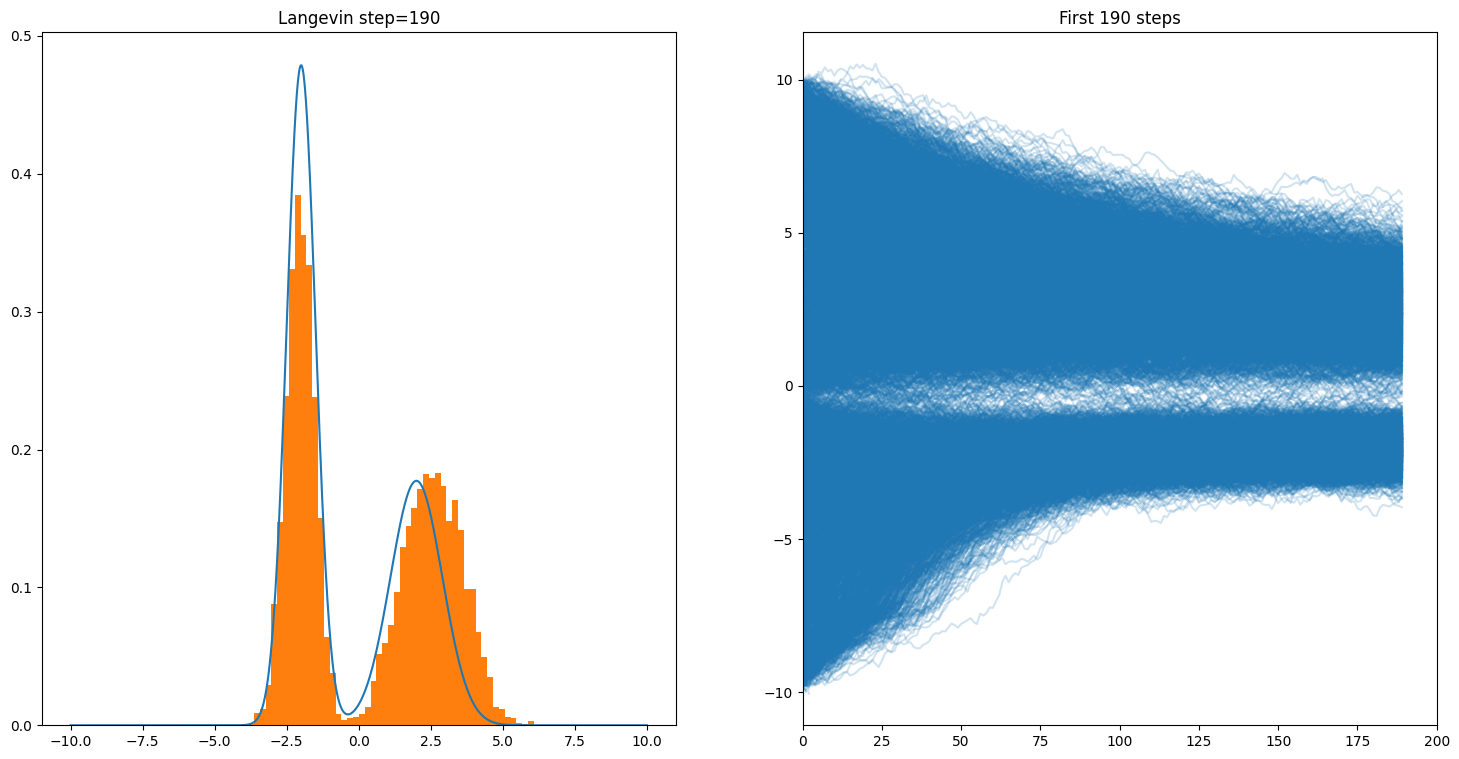

In [11]:
# plt.rcParams['text.usetex'] = True

step_size = 10

for i in range(len(x_ts)//step_size):
    
    fig = plt.figure(figsize=(18, 9))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    ax1.clear()
    ax1.plot(x, p_x, label=r'$p_{\text{data}}(\bf{x})$')
    ax1.hist(x_ts[i*step_size], density=True, bins=50, label=r'$p(\bf{x}; \bm{\theta})$')
    ax1.set_xlim(-10, 10)
    ax1.set_title(f'Langevin step={i*step_size}')
    
    ax2.plot(x_ts[:i*step_size], color='C0', alpha=0.2)
    ax2.set_xlim(0, 200)
    ax2.set_title(f'First {i*step_size} steps')
    
    plt.savefig(f"../outputs/langevin/t-{i}.png", dpi=200, bbox_inches='tight')
    